![](https://www.ishn.com/ext/resources/Issues/2019/06-June/ISHN0619_C2_pic.jpg?1559575718)

# **Introduction and description of the data and the project**

This project's objective is to use a machine learning and data mining algorithms that predict whether a person in a given county is likely to have a specific infectious disease based on a data from a dataset from Kaggle called [Infectious Disease 2001-2004](https://www.kaggle.com/datasets/jahaidulislam/infectious-disease-2001-2014).

Infectious diseases, caused by pathogens like viruses, bacteria, fungi, and parasites, spread through various means including direct contact, droplets, airborne particles, and contaminated food or water. These diseases significantly impact public health and the global economy, with varying incidence and prevalence across different regions and populations over time.

The dataset tracks outbreaks by year and state, detailing the location, type, duration, and demographic information of affected individuals, such as age, gender, and race. It also includes information on the suspected or confirmed pathogens, modes of transmission, and outbreak sources, covering a range of diseases like foodborne illnesses, respiratory infections, and sexually transmitted infections.

Dataset Features:
*   Disease
*   County
*   Year
*   Sex
*   Count
*   Population
*   Rate
*   CI.lower
*   CI.upper
*   Unstable

<div align="center" style="font-size:14px;">
  <h2>Importing the needed libraries</h2>
</div>

In [1]:
# Loading of data
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True # When performing certain operations on a pandas DataFrame, it may create copies of the data even if the operation does not actually modify the data. That's why we use this configuration option for the pandas library that helps manage how data is copied.

# Visualization of data
import matplotlib.pyplot as plt

<div align="center" style="font-size:14px;">
  <h2>Loading of dataset</h2>
</div>

In [2]:
my_df = pd.read_csv('/kaggle/input/infectious-disease-2001-2014/Infectious Disease 2001-2014.csv')
my_df.head()


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,Total,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,Female,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,Male,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,Total,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,Female,145,17555714,0.826,0.697,0.972,


<div align="center" style="font-size:14px;">
  <h2>Data analysis and visualization</h2>
</div>

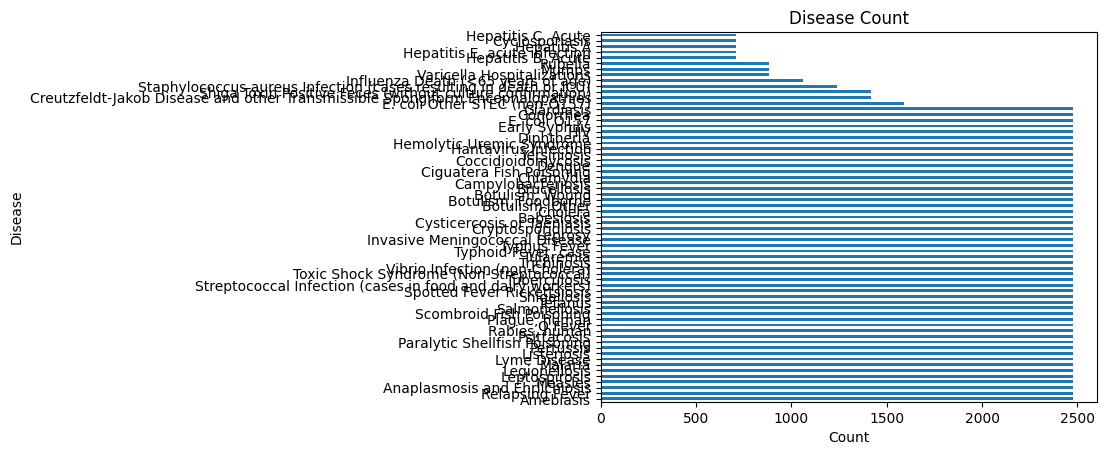

In [3]:
my_df['Disease'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.title('Disease Count')
plt.show()

In [4]:
my_df.describe()

,Year,Count,Population,Rate,CI.lower,CI.upper
count,141777.000000,141777.000000,1.417770e+05,141777.000000,141777.000000,141777.000000
mean,2007.857678,81.368438,8.299702e+05,6.984715,5.726249,28.912777
std,4.052999,1954.637660,3.452198e+06,44.861027,41.479404,87.209601
min,2001.000000,0.000000,5.330000e+02,0.000000,0.000000,0.010000
25%,2004.000000,0.000000,2.871500e+04,0.000000,0.000000,1.495000
50%,2008.000000,0.000000,1.239460e+05,0.000000,0.000000,5.233000
75%,2011.000000,1.000000,4.119620e+05,0.203000,0.010000,17.814000
max,2014.000000,174557.000000,3.850149e+07,1020.550000,992.007000,1632.966000


Column: Disease, Type: object
Skipping non-numeric column: Disease
Column: County, Type: object
Skipping non-numeric column: County
Column: Year, Type: int64


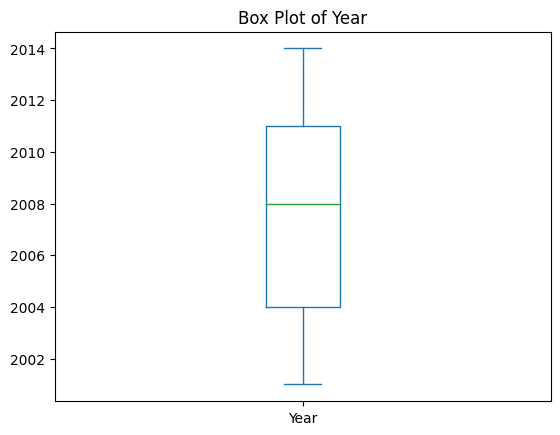

Column: Sex, Type: object
Skipping non-numeric column: Sex
Column: Count, Type: int64


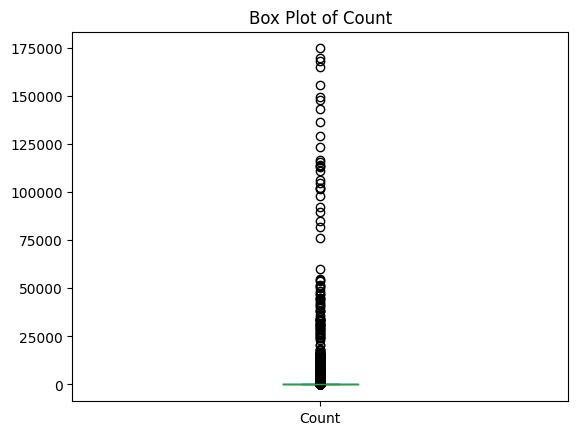

Column: Population, Type: int64


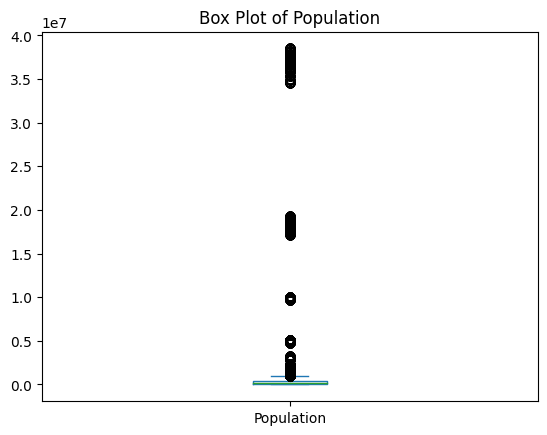

Column: Rate, Type: float64


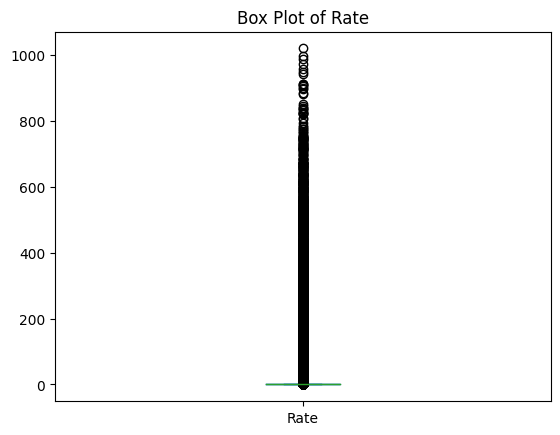

Column: CI.lower, Type: float64


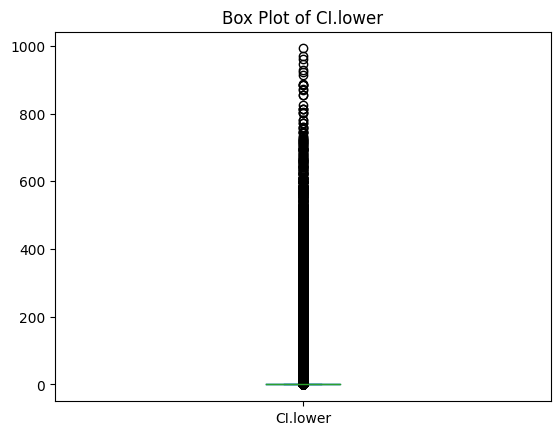

Column: CI.upper, Type: float64


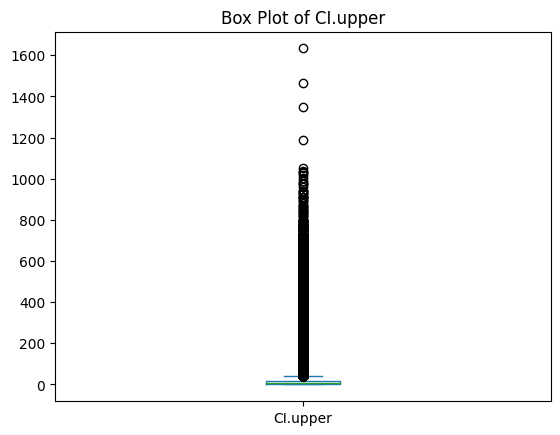

In [5]:
for col in my_df.columns[0:-1]:
    # Print column name and type
    print(f"Column: {col}, Type: {my_df[col].dtype}")
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(my_df[col]):
        my_df[col].plot.box(title=f"Box Plot of {col}")
        plt.show()
    else:
        print(f"Skipping non-numeric column: {col}")

<p style="font-size:14px;">
In the obtained box plots we can see that there are a lot of outliers (in all of them, except the box plot for the column "Year"). We have to decide what should we do with them and understand if they are important for our problem solving or not. We will use <strong>log transformation</strong>.
</p>

In [6]:
def log_transform_outliers(series):
    # Define threshold for outliers (e.g., 1.5 times IQR)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR

    # Apply log transformation to outliers
    return series.apply(lambda x: np.log(x) if x > threshold else x)

# Create a new DataFrame for transformed data
my_df_transformed = my_df.copy()

# Apply log transformation to all numeric columns
for col in my_df_transformed.select_dtypes(include=np.number):
    my_df_transformed[f'{col}_transformed'] = log_transform_outliers(my_df_transformed[col])

print("\nTransformed Dataset:")
my_df_transformed.head()



Transformed Dataset:


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable,Year_transformed,Count_transformed,Population_transformed,Rate_transformed,CI.lower_transformed,CI.upper_transformed
0,Amebiasis,California,2001,Total,571,34514777,1.654,1.521,1.796,,2001,6.347389,17.356898,0.503197,0.419368,1.796
1,Amebiasis,California,2001,Female,176,17340743,1.015,0.871,1.176,,2001,5.170484,16.668569,0.014889,-0.138113,1.176
2,Amebiasis,California,2001,Male,365,17174034,2.125,1.913,2.355,,2001,5.899897,16.658909,0.753772,0.648673,2.355
3,Amebiasis,California,2002,Total,442,34940334,1.265,1.150,1.389,,2002,6.091310,17.369152,0.235072,0.139762,1.389
4,Amebiasis,California,2002,Female,145,17555714,0.826,0.697,0.972,,2002,4.976734,16.680890,-0.191161,-0.360970,0.972


Year                         Axes(0.125,0.712609;0.227941x0.167391)
Count                     Axes(0.398529,0.712609;0.227941x0.167391)
Population                Axes(0.672059,0.712609;0.227941x0.167391)
Rate                         Axes(0.125,0.511739;0.227941x0.167391)
CI.lower                  Axes(0.398529,0.511739;0.227941x0.167391)
CI.upper                  Axes(0.672059,0.511739;0.227941x0.167391)
Year_transformed              Axes(0.125,0.31087;0.227941x0.167391)
Count_transformed          Axes(0.398529,0.31087;0.227941x0.167391)
Population_transformed     Axes(0.672059,0.31087;0.227941x0.167391)
Rate_transformed                 Axes(0.125,0.11;0.227941x0.167391)
CI.lower_transformed          Axes(0.398529,0.11;0.227941x0.167391)
CI.upper_transformed          Axes(0.672059,0.11;0.227941x0.167391)
dtype: object

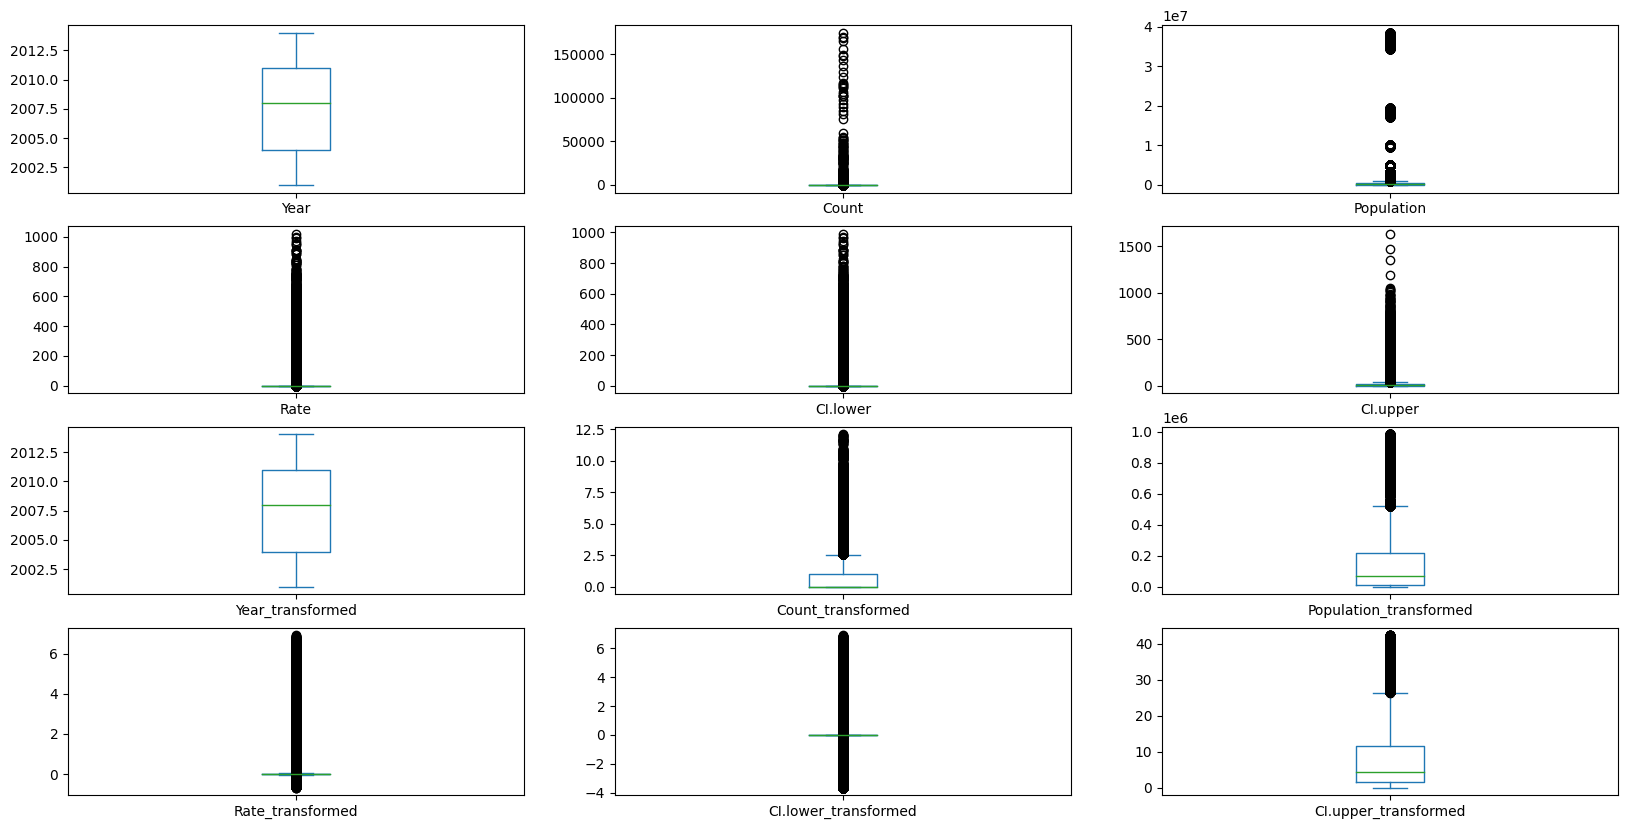

In [7]:
my_df_transformed.plot(kind='box', subplots=True, layout=(4,3), sharex=False, figsize=(20, 10))


We can see that we have some improvement and we can proceed with working on the data.
Next, we check if there are NA values and if yes, we delete them.

In [8]:
my_df.isna().sum()

Disease       0
County        0
Year          0
Sex           0
Count         0
Population    0
Rate          0
CI.lower      0
CI.upper      0
Unstable      0
dtype: int64

We see that we don't have NA values, so we proceed with the model selection.

<div align="center" style="font-size:14px;">
  <h2>Data splitting and model selection</h2>
</div>